# Results

In [2]:
import numpy as np
import tensorflow as tf
import os

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend, initializers, mixed_precision
from tensorflow.keras.utils import audio_dataset_from_directory
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
model = tf.keras.models.load_model('code/test_models.py')

In [3]:
policy = mixed_precision.Policy('float32')
mixed_precision.set_global_policy(policy)
sns.set_style("darkgrid")

In [4]:
df_train, df_val = audio_dataset_from_directory(directory='/Users/max/Documents/HDA/project/data/speech_commands_v0.02/', 
                                                labels='inferred', 
                                                label_mode='int', 
                                                batch_size=32, 
                                                validation_split=0.2, 
                                                subset='both', 
                                                seed=0,
                                                shuffle=True)
labels = np.array(df_train.class_names)

Found 105835 files belonging to 36 classes.
Using 84668 files for training.
Using 21167 files for validation.


In [5]:
labels

array(['_background_noise_', 'backward', 'bed', 'bird', 'cat', 'dog',
       'down', 'eight', 'five', 'follow', 'forward', 'four', 'go',
       'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off',
       'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three',
       'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero'], dtype='<U18')

In [5]:
def squeeze_samples(audio, label):
    audio = tf.squeeze(audio, axis=-1)
    return audio, label

df_train = df_train.map(squeeze_samples, tf.data.AUTOTUNE)
df_val = df_val.map(squeeze_samples, tf.data.AUTOTUNE)

def get_spectrogram(waveform, frame_length=550, frame_step=128, mel=True):
    
    spectrogram = tf.signal.stft(waveform, frame_length=frame_length, frame_step=frame_step)
    spectrogram = tf.abs(spectrogram)
    num_spectrogram_bins = spectrogram.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 0.0, 3000.0, 120
    mel_matrix = tf.signal.linear_to_mel_weight_matrix(num_mel_bins=num_mel_bins, 
                                                       num_spectrogram_bins=num_spectrogram_bins, 
                                                       sample_rate=16000, 
                                                       lower_edge_hertz=lower_edge_hertz, 
                                                       upper_edge_hertz=upper_edge_hertz)
    mel_spectrogram = tf.tensordot(spectrogram, mel_matrix, 1)
    mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(mel_matrix.shape[-1:]))
    mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    
    if mel:
        return mel_spectrogram[...,tf.newaxis]
    return np.log(spectrogram.numpy().T + np.finfo(float).eps)[..., tf.newaxis]

def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    height = spectrogram.shape[0]
    width = spectrogram.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, spectrogram)
    
def make_spec_ds(ds):
    return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

def squeeze_audio(x):
    x = tf.squeeze(x, axis=0)
    return x

In [6]:
df_test = df_val.shard(num_shards=2, index=0)
df_val = df_val.shard(num_shards=2, index=1)

val_spectrogram_ds = make_spec_ds(df_val).prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = make_spec_ds(df_test).prefetch(tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [53]:
os.listdir('models/')

['model_3',
 'model_4',
 'model_2',
 'model_CNN_2convLSTM',
 'model_CNN_Bi_2convLSTM_AT',
 'CNN_Bi_2convLSTM_softmax',
 'model_CNN',
 'model_9',
 'model_7',
 'CNN_Bi_3convLSTMPooling_softmax',
 'model_1',
 'model_6',
 'model_8',
 'CNN_Bi_2convLSTM_AT_softmax',
 'model_CNN_Bi_2convLSTM',
 'model_residual_CNN_RNN',
 'model_CNN_Bi_1convLSTM_1LSTM',
 'CNN_Bi_2convLSTMPooling_softmax',
 '.idea']

In [54]:
Models = os.listdir('models/')
Models = [i for i in Models if '.' not in i]
Models

['model_3',
 'model_4',
 'model_2',
 'model_CNN_2convLSTM',
 'model_CNN_Bi_2convLSTM_AT',
 'CNN_Bi_2convLSTM_softmax',
 'model_CNN',
 'model_9',
 'model_7',
 'CNN_Bi_3convLSTMPooling_softmax',
 'model_1',
 'model_6',
 'model_8',
 'CNN_Bi_2convLSTM_AT_softmax',
 'model_CNN_Bi_2convLSTM',
 'model_residual_CNN_RNN',
 'model_CNN_Bi_1convLSTM_1LSTM',
 'CNN_Bi_2convLSTMPooling_softmax']

In [454]:
accuracy = []
for i in Models:
    model = tf.keras.models.load_model('models/' + i) 
    loss, acc = model.evaluate(val_spectrogram_ds)
    accuracy.append((i, acc, loss))

331/331 [==============================] - 20s 59ms/step - loss: 0.8903 - accuracy: 0.8345


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/keras/layers/core/lambda_layer.py:324: UserWarning: test_models is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


331/331 [==============================] - 25s 72ms/step - loss: 2.2145 - accuracy: 0.4373


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/keras/layers/core/lambda_layer.py:324: UserWarning: test_models is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


331/331 [==============================] - 30s 87ms/step - loss: 0.5405 - accuracy: 0.8878


In [469]:
accuracy = np.array(accuracy)
best_4 = accuracy[np.argsort(accuracy[:,1])[::-1]]
best_4

array([['CNN_Bi_3convLSTMPooling_softmax', '0.8965484499931335',
        '0.49274832010269165'],
       ['CNN_Bi_2convLSTM_softmax', '0.8882269263267517',
        '0.7115705013275146'],
       ['CNN_Bi_2convLSTMPooling_softmax', '0.8877541422843933',
        '0.5405086278915405'],
       ['model_CNN_Bi_2convLSTM', '0.8712056875228882',
        '0.6106173992156982'],
       ['model_CNN_2convLSTM', '0.834515392780304', '0.89031982421875'],
       ['CNN_Bi_2convLSTM_AT_softmax', '0.8151299953460693',
        '0.6180425882339478'],
       ['model_CNN_Bi_2convLSTM_AT', '0.8063356876373291',
        '0.6371258497238159'],
       ['model_CNN_Bi_1convLSTM_1LSTM', '0.7527186870574951',
        '0.9774661064147949'],
       ['model_CNN', '0.7296453714370728', '1.0641108751296997'],
       ['model_residual_CNN_RNN', '0.6962648034095764',
        '2.318350076675415'],
       ['model_9', '0.6639243364334106', '1.3463281393051147'],
       ['model_3', '0.536453902721405', '1.8183108568191528'],
    

In [487]:
models=['CNN-Bi-2ConvLSTM_AT', 'CNN-Bi-2ConvLSTM', 'CNN-Bi-2ConvLSTMPooling', 'CNN-Bi-3ConvLSTMPooling']

In [504]:
epoch_acc_path = '../epoch_acc/'
epoch_acc = [i for i in os.listdir(epoch_acc_path) if i.endswith('.csv')]
epoch_acc = np.sort(epoch_acc)
df_epoch_acc = []
for i in range(len(epoch_acc)):
    data = pd.read_csv(epoch_acc_path + epoch_acc[i])
    data['Wall time'] = (data['Wall time'] - data['Wall time'].min())/3600
    data['Model'] = models[i]
    df_epoch_acc.append(data)
    
df_epoch_acc = pd.concat(df_epoch_acc, ignore_index=True)

In [505]:
epoch_loss_path = '../epoch_loss/'
epoch_loss = [i for i in os.listdir(epoch_loss_path) if i.endswith('.csv')]
epoch_loss = np.sort(epoch_loss)
df_epoch_loss = []
for i in range(len(epoch_loss)):
    data = pd.read_csv(epoch_loss_path + epoch_loss[i])
    data['Wall time'] = (data['Wall time'] - data['Wall time'].min())/3600
    data['Model'] = models[i]
    df_epoch_loss.append(data)
    
df_epoch_loss = pd.concat(df_epoch_loss, ignore_index=True)

In [506]:
acc_vs_it_path = '../acc_vs_it/'
acc_vs_it = [i for i in os.listdir(acc_vs_it_path) if i.endswith('.csv')]
acc_vs_it = np.sort(acc_vs_it)
df_acc_vs_it = []
for i in range(len(acc_vs_it)):
    data = pd.read_csv(acc_vs_it_path + acc_vs_it[i])
    data['Wall time'] = (data['Wall time'] - data['Wall time'].min())/3600
    data['Model'] = models[i]
    df_acc_vs_it.append(data)
    
df_acc_vs_it = pd.concat(df_acc_vs_it, ignore_index=True)

In [507]:
loss_vs_it_path = '../loss_vs_it/'
loss_vs_it = [i for i in os.listdir(loss_vs_it_path) if i.endswith('.csv')]
loss_vs_it = np.sort(loss_vs_it)
df_loss_vs_it = []
for i in range(len(loss_vs_it)):
    data = pd.read_csv(loss_vs_it_path + loss_vs_it[i])
    data['Wall time'] = (data['Wall time'] - data['Wall time'].min())/3600
    data['Model'] = models[i]
    df_loss_vs_it.append(data)
    
df_loss_vs_it= pd.concat(df_loss_vs_it, ignore_index=True)

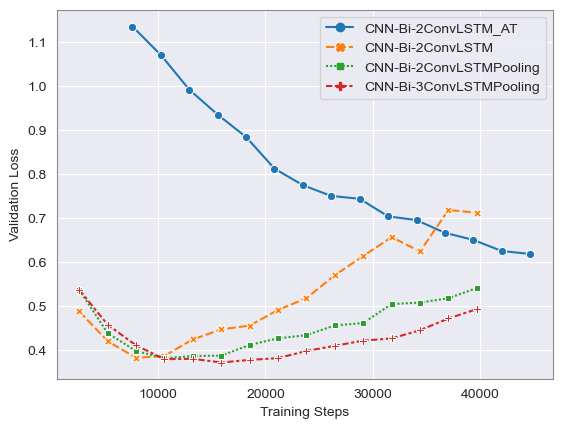

In [508]:
palette=["C0", "C1", "C2", "C3"]
sns.set_style("darkgrid", {"axes.edgecolor": ".55",})
g = sns.lineplot(x="Step", y="Value", hue='Model', data=df_loss_vs_it, palette=palette, style='Model',  markers=True)
sns.move_legend(g, "center right")
plt.xlabel('Training Steps')
plt.ylabel('Validation Loss')
plt.legend(loc=0)

leg = g.get_legend()
for i in range(4):
    leg.legendHandles[i].set_color(palette[i])

g.grid(visible=True, which='major')
plt.show()

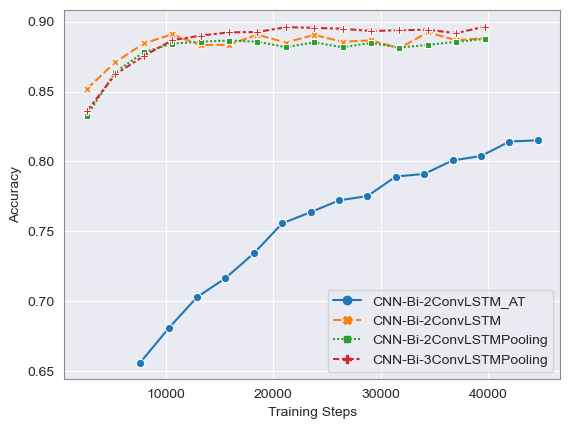

In [509]:
palette=["C0", "C1", "C2", "C3"]
sns.set_style("darkgrid", {"axes.edgecolor": ".55",})
g = sns.lineplot(x="Step", y="Value", hue='Model', data=df_acc_vs_it, palette=palette, style='Model',  markers=True)
sns.move_legend(g, "center right")
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.legend(loc=0)

leg = g.get_legend()
for i in range(4):
    leg.legendHandles[i].set_color(palette[i])
    

g.grid(visible=True, which='major')
plt.show()

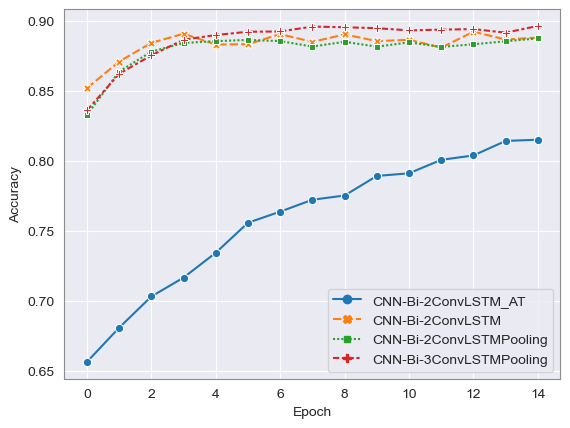

In [515]:
palette=["C0", "C1", "C2", "C3"]
sns.set_style("darkgrid", {"axes.edgecolor": ".55",})
g = sns.lineplot(x="Step", y="Value", hue='Model', data=df_epoch_acc, markers=True, style='Model', palette=palette)
sns.move_legend(g, "center right")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=0)

leg = g.get_legend()
for i in range(4):
    leg.legendHandles[i].set_color(palette[i])

g.grid(visible=True, which='major')
plt.show()

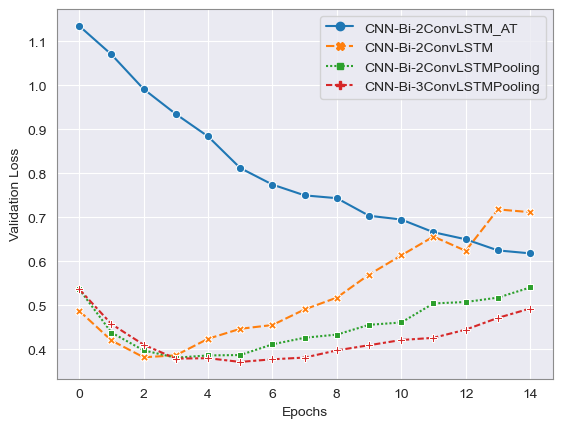

In [511]:
palette=["C0", "C1", "C2", "C3"]
sns.set_style("darkgrid", {"axes.edgecolor": ".55",})
g = sns.lineplot(x="Step", y="Value", hue='Model', data=df_epoch_loss, palette=palette, style='Model',  markers=True)
sns.move_legend(g, "center right")
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend(loc=0)

leg = g.get_legend()
for i in range(4):
    leg.legendHandles[i].set_color(palette[i])

g.grid(visible=True, which='major')
plt.show()

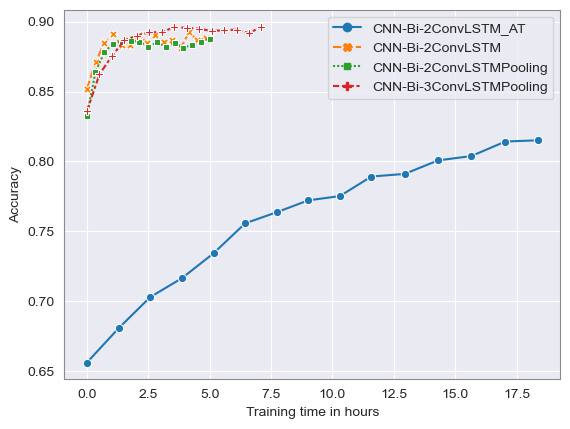

In [512]:
palette=["C0", "C1", "C2", "C3"]
sns.set_style("darkgrid", {"axes.edgecolor": ".55",})
g = sns.lineplot(x="Wall time", y="Value", hue='Model', data=df_acc_vs_it, palette=palette, style='Model',  markers=True)
sns.move_legend(g, "center right")
plt.xlabel('Training time in hours')
plt.ylabel('Accuracy')
plt.legend(loc=0)

leg = g.get_legend()
for i in range(4):
    leg.legendHandles[i].set_color(palette[i])

g.grid(visible=True, which='major')
plt.show()

In [165]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [244]:
models 

['CNN-Bi-2ConvLSTM',
 'CNN-Bi-3ConvLSTMPooling',
 'CNN-Bi-2ConvLSTMPooling',
 'CNN-Bi-2ConvLSTM_AT']

In [245]:
models_model = ['models/CNN_Bi_2convLSTM_softmax', 'models/CNN_Bi_3convLSTMPooling_softmax/', 'models/CNN_Bi_2convLSTMPooling_softmax/', 'models/CNN_Bi_2convLSTM_AT_softmax/']

331/331 [==============================] - 28s 83ms/step


/var/folders/0c/s31t6sbs7x92vc54xc4x32n40000gn/T/ipykernel_13268/1527139880.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_true = np.array([s.numpy() for s in y_true])
/var/folders/0c/s31t6sbs7x92vc54xc4x32n40000gn/T/ipykernel_13268/1527139880.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[cols][rows].yaxis.set_ticklabels(labels, rotation=0, ha='right', fontsize=9)


331/331 [==============================] - 29s 84ms/step


/var/folders/0c/s31t6sbs7x92vc54xc4x32n40000gn/T/ipykernel_13268/1527139880.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_true = np.array([s.numpy() for s in y_true])


331/331 [==============================] - 27s 78ms/step


/var/folders/0c/s31t6sbs7x92vc54xc4x32n40000gn/T/ipykernel_13268/1527139880.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_true = np.array([s.numpy() for s in y_true])
/var/folders/0c/s31t6sbs7x92vc54xc4x32n40000gn/T/ipykernel_13268/1527139880.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[cols][rows].yaxis.set_ticklabels(labels, rotation=0, ha='right', fontsize=9)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/keras/layers/core/lambda_layer.py:324: UserWarning: test_models is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


331/331 [==============================] - 85s 255ms/step


/var/folders/0c/s31t6sbs7x92vc54xc4x32n40000gn/T/ipykernel_13268/1527139880.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_true = np.array([s.numpy() for s in y_true])


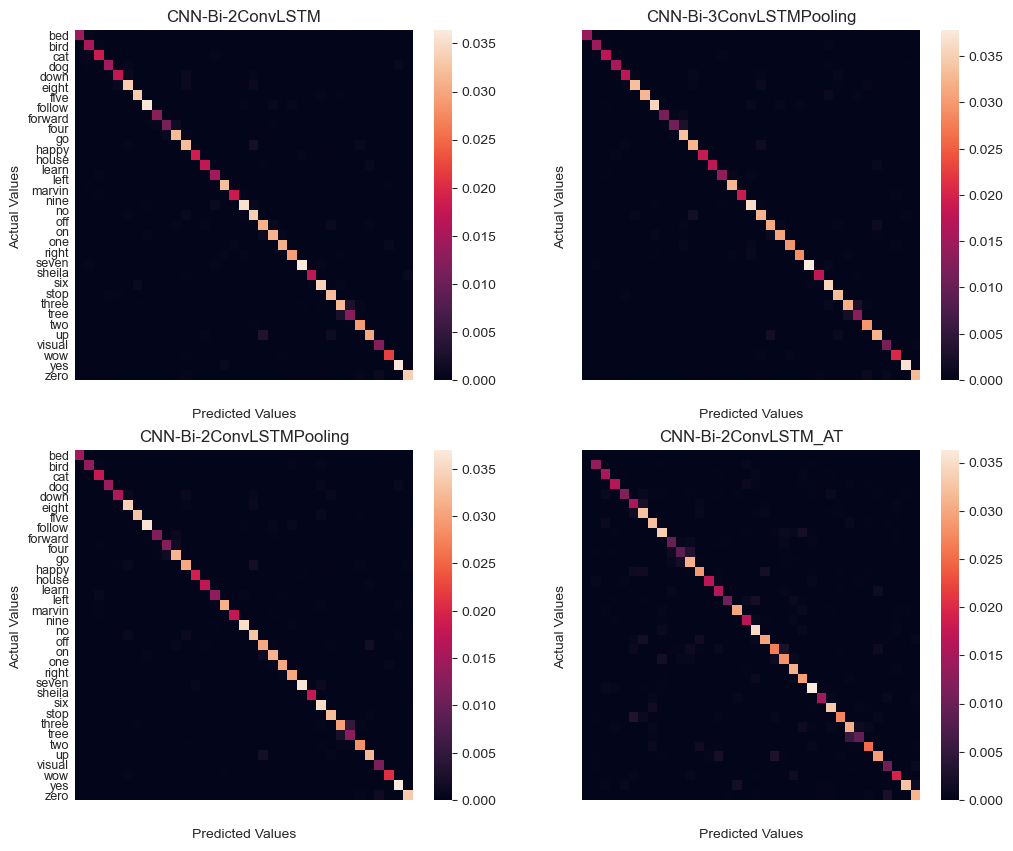

In [453]:
import matplotlib.ticker as ticker
import matplotlib
sns.set_style("darkgrid", {"axes.edgecolor": ".55",})

labels = [i for i in labels if '_' not in i]

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

for i in range(4):
    
    cols = i // 2
    rows = i % 2
    
    model = tf.keras.models.load_model(models_model[i])

    y_pred = model.predict(val_spectrogram_ds)
    x_true, y_true = tuple(zip(*val_spectrogram_ds))

    y_true = np.array([s.numpy() for s in y_true])
    y_true2 = np.array([])
    for l in y_true:
        y_true2 = np.hstack((y_true2, l))
    y_pred = np.argmax(y_pred, 1) 

    mat = confusion_matrix(y_true2, y_pred, normalize='all')
    #ax[cols][rows] = ConfusionMatrixDisplay(confusion_matrix = mat, display_labels=labels)
    sns.heatmap(mat, ax=ax[cols][rows])

    ax[cols][rows].set_title(models[int(i)]);
    ax[cols][rows].set_xlabel('\nPredicted Values')
    ax[cols][rows].set_ylabel('Actual Values ');
    
    if rows == 0:
    
        ax[cols][rows].xaxis.set_ticklabels([])
        ax[cols][rows].yaxis.set_major_locator(ticker.MultipleLocator(1.03))
        ax[cols][rows].yaxis.set_ticklabels(labels, rotation=0, ha='right', fontsize=9)

        dx = 3/72.
        dy = -5/72. 
        offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
        for label in ax[cols][rows].yaxis.get_majorticklabels():
            label.set_transform(label.get_transform() + offset)
    
    else:
        ax[cols][rows].xaxis.set_ticklabels([])
        ax[cols][rows].yaxis.set_ticklabels([])

plt.show()

In [445]:
model = tf.keras.models.load_model('models/CNN_Bi_3convLSTMPooling_softmax/')
x = tf.io.read_file('tests/backward.wav')
test_audio, samplerate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=-1)
test_audio = tf.reshape(test_audio, (1, -1))
test_audio = test_audio.numpy()
samplerate = samplerate.numpy()

In [446]:
test_audio.shape

(1, 25240)

In [447]:
test_audio = test_audio[:,2000:18000]

In [448]:
test_audio.shape

(1, 16000)

In [449]:
from IPython.display import Audio
Audio(test_audio, rate=16000)

In [450]:
import scipy.signal as sps

test_spectrogram = get_spectrogram(tf.convert_to_tensor(test_audio, dtype=tf.float32))

In [451]:
test_spectrogram.shape

TensorShape([1, 121, 120, 1])

In [452]:
labels = np.array(df_train.class_names)
labels[np.argmax(model.predict(test_spectrogram))]

1/1 [==============================] - 1s 508ms/step


'backward'

In [464]:
models_model

['models/CNN_Bi_2convLSTM_softmax',
 'models/CNN_Bi_3convLSTMPooling_softmax/',
 'models/CNN_Bi_2convLSTMPooling_softmax/',
 'models/CNN_Bi_2convLSTM_AT_softmax/']

In [463]:
for i in range(4):

    model = tf.keras.models.load_model(models_model[i])
    print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 64, 64, 1)         0         
                                                                 
 normalization_1 (Normalizat  (None, 64, 64, 1)        3         
 ion)                                                            
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 10)        820       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 10)       40        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 10)       0         
 )                                                               
                                                        

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/keras/layers/core/lambda_layer.py:324: UserWarning: test_models is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


Model: "Residual_CNN_RNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 121, 120, 1  0           []                               
                                )]                                                                
                                                                                                  
 resizing_2 (Resizing)          (None, 64, 64, 1)    0           ['input_4[0][0]']                
                                                                                                  
 normalization_4 (Normalization  (None, 64, 64, 1)   3           ['resizing_2[0][0]']             
 )                                                                                                
                                                                                   

In [516]:
for i in range(4):

    model = tf.keras.models.load_model(models_model[i])

    y_pred = model.predict(val_spectrogram_ds)

331/331 [==============================] - 15s 43ms/step


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/keras/layers/core/lambda_layer.py:324: UserWarning: test_models is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


331/331 [==============================] - 55s 165ms/step
